In [165]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [166]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [167]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [168]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 7.54
ss.m_v = 0.49
ss.r_K = 0.14
ss.r_ell = 1.68
ss.r_E = 1.00
ss.ell = 56.09
ss.w = 1.67
ss.K = 85.82
ss.I = 8.58
ss.Y = 159.42
ss.G = 39.85
ss.B_G = 0.00
ss.tau = 0.48
solving for household behavior: result.converged = True
ss.C = 51.74
ss.B = -55.83
ss.X = 143.09
ss.M = 136.98
par.phi = 0.974


**Household behavior:**

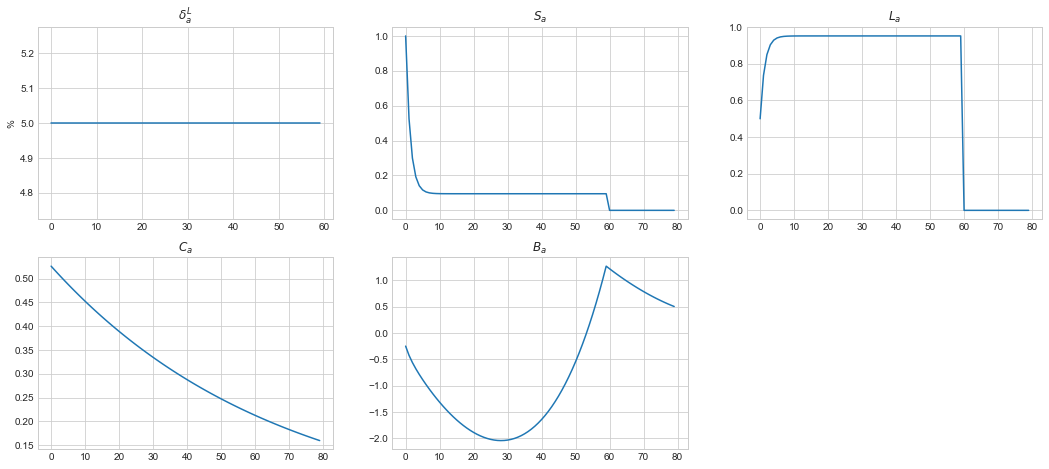

In [169]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [170]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [171]:
%time model.evaluate_blocks(py=True)

CPU times: user 3.36 s, sys: 41.6 ms, total: 3.4 s
Wall time: 3.44 s


**Check errors:**

In [172]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 2.22e-16
Bq_match            : abs. max = 3.99e-12
FOC_capital_agency  : abs. max = 5.55e-16
FOC_K_ell           : abs. max = 2.22e-16
FOC_E_Y_KL          : abs. max = 1.67e-16
mkt_clearing        : abs. max = 0.00e+00
output_price        : abs. max = 0.00e+00


In [173]:
import blocks

# inputs 
Y = sol.Y
P_Y_0 = sol.P_Y_0

# outputs
P_Y = sol.P_Y

# targets 
output_price = sol.output_price

# evaluations
P_Y_lag1 = lag_n(ss.P_Y,P_Y,1)
P_Y_lag2 = lag_n(ss.P_Y,P_Y,2)
P_Y_lead = lead(P_Y,ss.P_Y)
Y_lead = lead(Y,ss.Y)

part_i = (P_Y/P_Y_lag1)/(P_Y_lag1/P_Y_lag2)
part_ii = (P_Y_lead/P_Y)/(P_Y/P_Y_lag1)

term_a = -(par.iota_0/(par.eta_C-1))*(part_i-1)*part_i*P_Y
term_b = 2*par.beta*(par.iota_0/(par.eta_C-1))*(part_ii-1)*part_ii*P_Y_lead*(Y_lead/Y)

output_price[:] = P_Y - (par.eta_C/(par.eta_C-1))*P_Y_0 - term_a - term_b

print(P_Y_0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

**First numba evaluation:**

In [174]:
%time model.evaluate_blocks()

CPU times: user 57.7 s, sys: 1.06 s, total: 58.8 s
Wall time: 1min 1s


**Time:**

In [175]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

10.8 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
88.4 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [176]:
%timeit model.evaluate_blocks(py=True)

623 ms ± 8.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [177]:
model.calc_jac(do_print=True)

Jacobian calculated in 39.3 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [178]:
model.set_exo_ss()

**Shock function:**

In [179]:
def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        shock_f = shock_size
        persistence_f = persistence_size ** np.arange(time_span)
        solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [180]:
Tshock = 50 #stød varer 50 år
shock = 0.2*ss.r_E #stød til energipriserne i produktionsfunktionen
persistence = 0.85**np.arange(Tshock) #Betyder at 0.85 opløftes i 1,2,3,4... op til 50. Gør at persistensen ved shocket dør ud, og at det smoothes mere.
sol.r_E[:Tshock] = ss.r_E + shock*persistence #Vi løser støddet til energipriserne; støddet varer fra 0-50. 

In [181]:
# Tshock = 20
# a = 0.1
# b = 10
# c = 4

# shock_t = np.zeros(Tshock)
# for i in range(Tshock):
    # shock_t[i] = ss.P_E + a/(1+b*(i-c)**2)
# sol.P_E[10:10+Tshock] = shock_t

Check errors when guessing at steady state -> excess demand

In [182]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 2.22e-16
Bq_match            : abs. max = 3.98e-12
FOC_capital_agency  : abs. max = 5.55e-16
FOC_K_ell           : abs. max = 2.22e-16
FOC_E_Y_KL          : abs. max = 7.02e-02
mkt_clearing        : abs. max = 0.00e+00
output_price        : abs. max = 6.33e-02


**Find IRF:**

In [183]:
model.find_IRF()

initial:
   max. abs. error = 7.02e-02
    2.22e-16 in bargaining_cond
    3.98e-12 in Bq_match
    5.55e-16 in FOC_capital_agency
    2.22e-16 in FOC_K_ell
    7.02e-02 in FOC_E_Y_KL
    0.00e+00 in mkt_clearing
    6.33e-02 in output_price

it = 0
 solve: t1-t0 = 1.0 secs
   max. abs. error = 7.02e-02
    6.97e-03 in bargaining_cond
    2.63e-01 in Bq_match
    3.42e-03 in FOC_capital_agency
    4.44e-03 in FOC_K_ell
    5.70e-03 in FOC_E_Y_KL
    1.60e+00 in mkt_clearing
    1.10e-03 in output_price
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 1
 solve: t1-t0 = 1.0 secs
   max. abs. error = 1.60e+00
    1.60e-03 in bargaining_cond
    1.21e-01 in Bq_match
    8.00e-04 in FOC_capital_agency
    4.27e-04 in FOC_K_ell
    3.76e-04 in FOC_E_Y_KL
    1.04e-01 in mkt_clearing
    6.58e-04 in output_price
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 2
 solve: t1-t0 = 1.0 secs
   max. abs. error = 1.21e-01
    5.49e-04 in bargaining_cond
    4.85e-02 in

**Plot:**

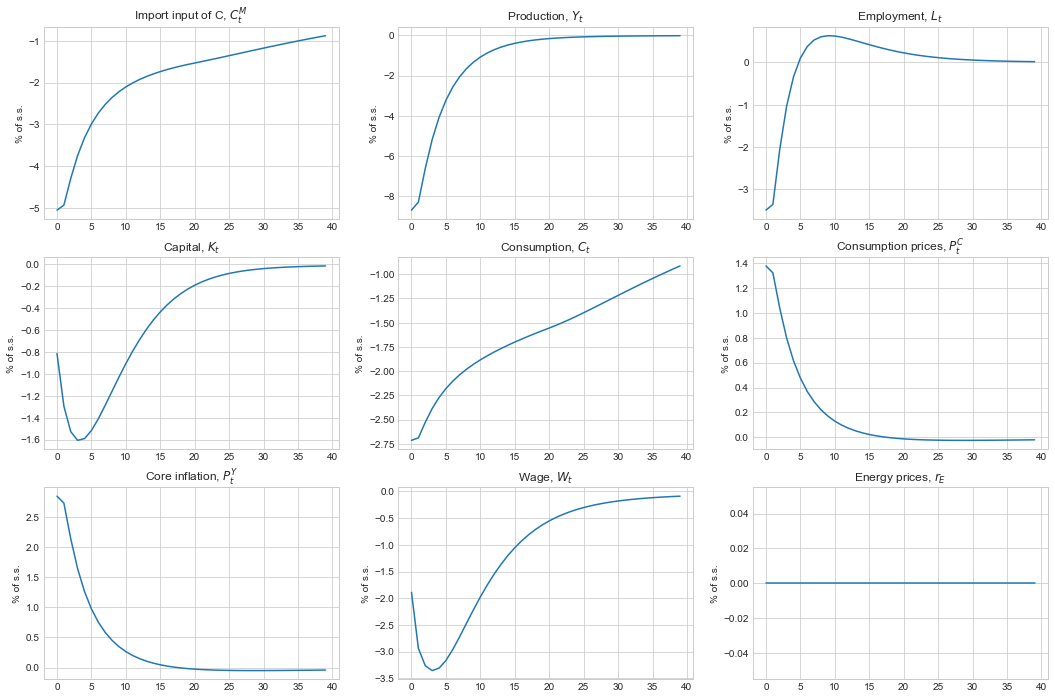

In [186]:
T_IRF = 40

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.C_Y[:T_IRF]/ss.C_Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import input of C, $C^M_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.P_C[:T_IRF])/(ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$');

ax = fig.add_subplot(3,3,7)
ax.plot(((sol.P_Y[:T_IRF])/(ss.P_Y)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Core inflation, $P^{Y}_t$');

ax = fig.add_subplot(3,3,8)
ax.plot(((sol.w[:T_IRF])/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Wage, $W_t$');

ax = fig.add_subplot(3,3,9)
ax.plot(((sol.P_E[:T_IRF])/(ss.P_E)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Energy prices, $r_E$');